# Data Loading and Exploration

## Import Libraries

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import mahalanobis
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import chi2
import warnings
import os
import sys
import contextlib

In [193]:
data = pd.read_csv('data/obesity.csv')
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [194]:
data.shape

(2111, 17)

In [195]:
data.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Somehow based on responses of "sometimes", "never", and "always" they produced continuous values?

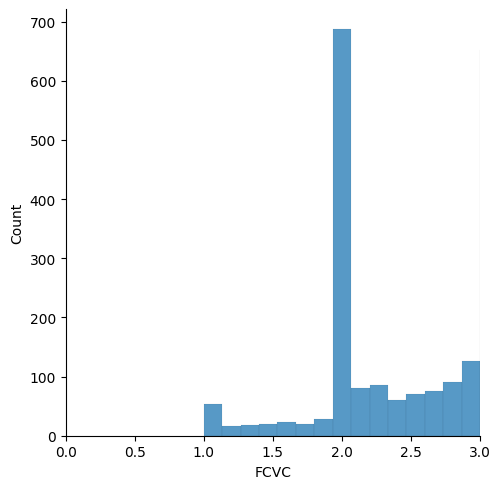

In [196]:
# plot the distribution of FCVC
sns.displot(data['FCVC'], bins=data['FCVC'].nunique())
# limit the x-axis to 3
plt.xlim(0, 3)
plt.show()

Also not sure how a question that asks "How many main meals do you have daily?" could produce so many different answers (and with such precision!). Three is the expected value, as is the norm.

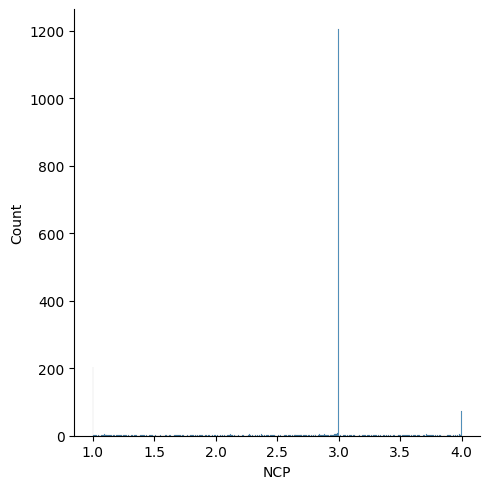

In [197]:
sns.displot(data['NCP'], bins=data['NCP'].nunique())
plt.show()

The majority do not exercise at all (unsurprising)

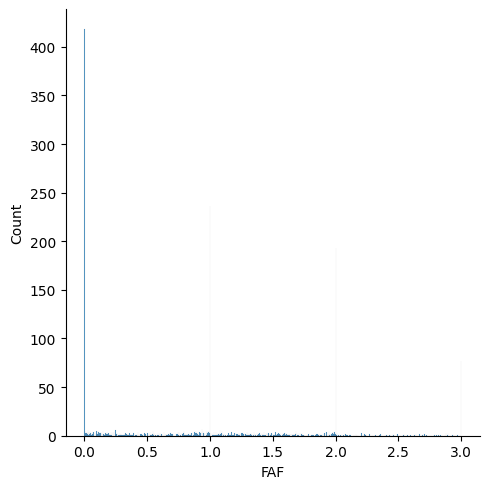

In [198]:
sns.displot(data['FAF'], bins=data['FAF'].nunique())
plt.show()

In [199]:
# Identify numerical and categorical columns
num_features = data.select_dtypes(include=['int64', 'float64']).columns
cat_features = data.select_dtypes(exclude=['int64', 'float64']).columns

In [200]:
data[cat_features].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
NObeyesdad                        7
dtype: int64

Seems to be an ordering to CAEC/CALC

In [201]:
print(data['NObeyesdad'].value_counts())
print(data['CAEC'].value_counts())
print(data['CALC'].value_counts())
print(data['MTRANS'].value_counts())

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          286
Insufficient_Weight    272
Name: count, dtype: int64
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64
MTRANS
Public_Transportation    1578
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64


After looking at the metadata, this is confirmed so we can move forward with encoding.

In [202]:
data_clean = data.copy()
data_clean['NObeyesdad'] = data_clean['NObeyesdad'].map({'Insufficient_Weight': -1, 'Normal_Weight': 0, 'Overweight_Level_I': 1, 'Overweight_Level_II': 2, 'Obesity_Type_I': 3, 'Obesity_Type_II': 4, 'Obesity_Type_III': 5})
data_clean['CAEC'] = data_clean['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data_clean['CALC'] = data_clean['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data_clean.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,1,no,2.0,no,0.0,1.0,0,Public_Transportation,0.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1,yes,3.0,yes,3.0,0.0,1,Public_Transportation,0.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,1,no,2.0,no,2.0,1.0,2,Public_Transportation,0.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,1,no,2.0,no,2.0,0.0,2,Walking,1.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,1,no,2.0,no,0.0,0.0,1,Public_Transportation,2.0


In [203]:
data_clean = pd.get_dummies(data_clean, drop_first=True, dtype=int)
data_clean.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,1,2.0,0.0,1.0,0,0.0,0,1,0,0,0,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,1,3.0,3.0,0.0,1,0.0,0,1,0,1,1,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,1,2.0,2.0,1.0,2,0.0,1,1,0,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,1,2.0,2.0,0.0,2,1.0,1,0,0,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,1,2.0,0.0,0.0,1,2.0,1,0,0,0,0,0,0,1,0


In [204]:
# rename columns to get rid of _yes (it's obvious)
data_clean.columns = data_clean.columns.str.replace('_yes', '')
data_clean.describe()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,2111.000000,2111.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.567110,2.469702,2.685479,1.140692,2.030749,1.010777,0.657866,0.731407,2.113270,0.505921,0.817148,0.883941,0.020843,0.045476,0.003316,0.005211,0.747513,0.026528
std,6.345968,0.093305,26.237871,2.380357,0.778193,0.468543,1.211104,0.850509,0.608927,0.515498,1.984999,0.500083,0.386637,0.320371,0.142893,0.208395,0.057502,0.072015,0.434542,0.160737
min,14.000000,1.450000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658689,1.000000,1.584812,0.127654,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.777890,1.700499,83.000000,2.387426,3.000000,1.000000,2.000000,1.000000,0.625350,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,26.000000,1.768464,107.430682,3.000000,3.000000,1.000000,2.479558,1.666821,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,61.000000,1.980000,173.000000,109.000000,4.000000,3.000000,50.000000,3.000000,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Appears to be only one missing value and so it will be dropped

In [205]:
data_clean[data_clean['NCP'].isna()]

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
115,17.0,1.75,57.0,3.0,NaN,2,2.0,NaN,1.0,0,0.0,0,0,1,0,0,0,0,0,0


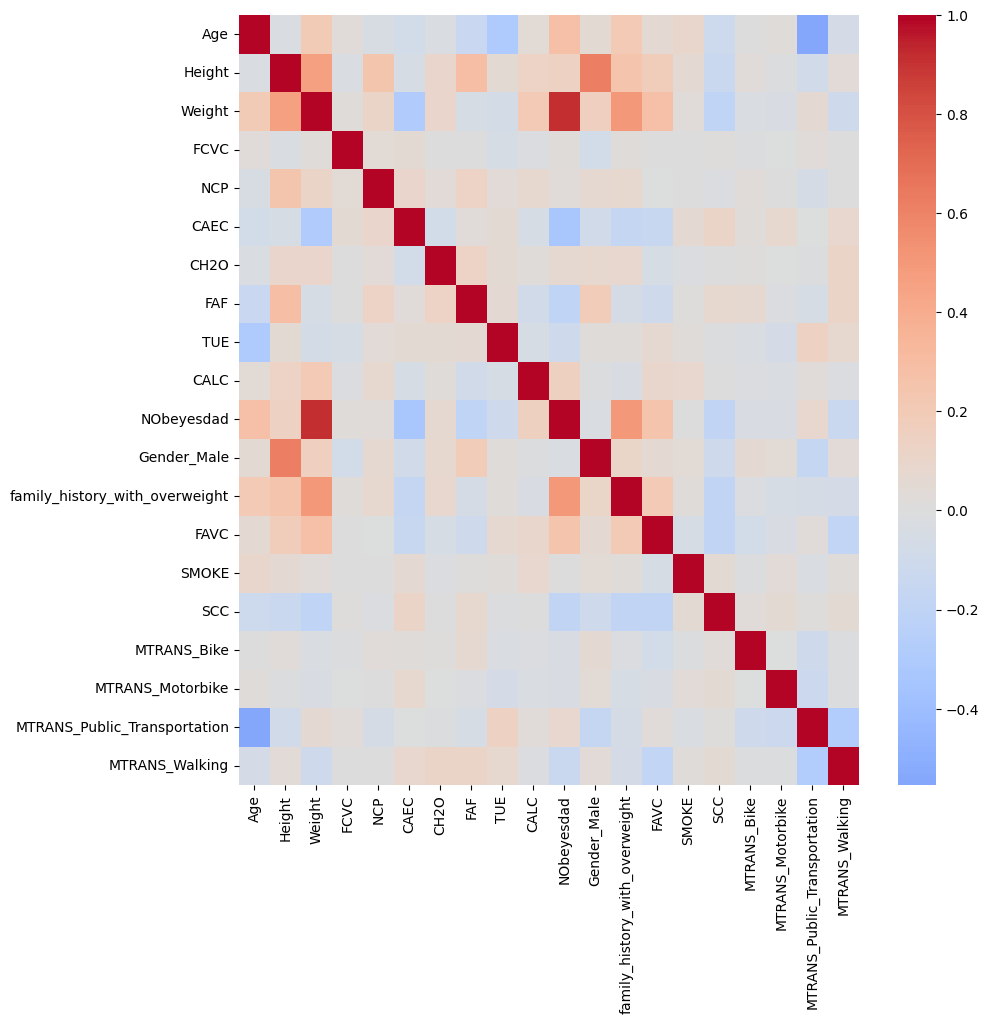

In [206]:
data_clean.dropna(inplace=True)
corr_matrix = data_clean.corr()
plt.figure(figsize=(10, 10))
# use heatmap, center the color scale at 0
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.show()

In [207]:
corr_matrix = data_clean.corr()

# Create a condensed correlation matrix
condensed_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().reset_index()
condensed_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Add a temporary column for sorting by absolute values
condensed_corr['AbsCorrelation'] = condensed_corr['Correlation'].abs()
condensed_corr_sorted = condensed_corr.sort_values('AbsCorrelation', ascending=False)
condensed_corr_sorted = condensed_corr_sorted.drop(columns=['AbsCorrelation'])

print(condensed_corr_sorted[:10])

      Feature 1                       Feature 2  Correlation
44       Weight                      NObeyesdad     0.912706
28       Height                     Gender_Male     0.619223
17          Age    MTRANS_Public_Transportation    -0.554256
146  NObeyesdad  family_history_with_overweight     0.505153
46       Weight  family_history_with_overweight     0.497771
19       Height                          Weight     0.464112
89         CAEC                      NObeyesdad    -0.329022
7           Age                             TUE    -0.297300
24       Height                             FAF     0.295124
39       Weight                            CAEC    -0.287784


In [208]:
# find any instance of NObeyesdad in the Feature columns of condensed_corr_sorted
condensed_corr_sorted[condensed_corr_sorted['Feature 1'] == 'NObeyesdad']

,Feature 1,Feature 2,Correlation
146,NObeyesdad,family_history_with_overweight,0.505153
147,NObeyesdad,FAVC,0.248308
149,NObeyesdad,SCC,-0.194837
153,NObeyesdad,MTRANS_Walking,-0.138807
152,NObeyesdad,MTRANS_Public_Transportation,0.086251
151,NObeyesdad,MTRANS_Motorbike,-0.037340
150,NObeyesdad,MTRANS_Bike,-0.036557
145,NObeyesdad,Gender_Male,-0.031507
148,NObeyesdad,SMOKE,0.003297


In [209]:
condensed_corr_sorted[condensed_corr_sorted['Feature 2'] == 'NObeyesdad']

,Feature 1,Feature 2,Correlation
44,Weight,NObeyesdad,0.912706
89,CAEC,NObeyesdad,-0.329022
9,Age,NObeyesdad,0.282197
114,FAF,NObeyesdad,-0.200681
135,CALC,NObeyesdad,0.151462
27,Height,NObeyesdad,0.133739
125,TUE,NObeyesdad,-0.108350
102,CH2O,NObeyesdad,0.066265
75,NCP,NObeyesdad,0.027115
60,FCVC,NObeyesdad,0.017727


In [210]:
def plot_data(x, y, data, hue=None):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, data=data, hue=hue)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

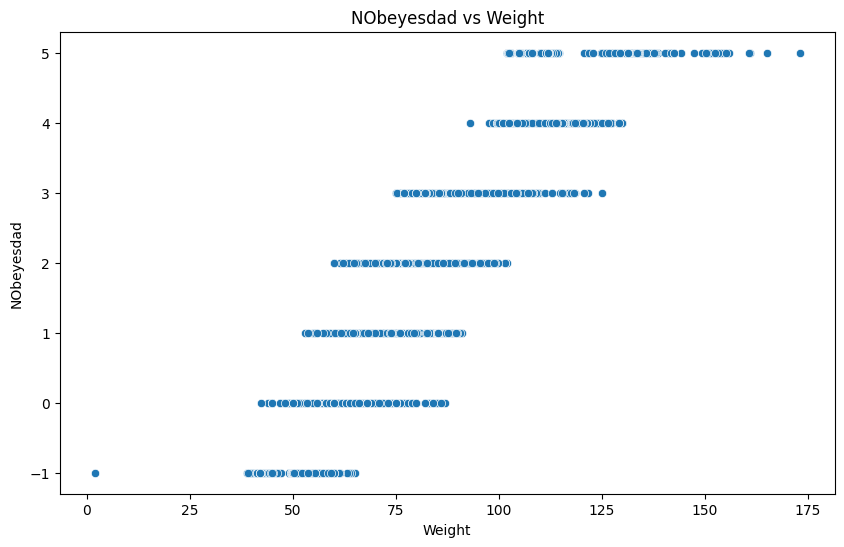

In [211]:
plot_data('Weight', 'NObeyesdad', data_clean)

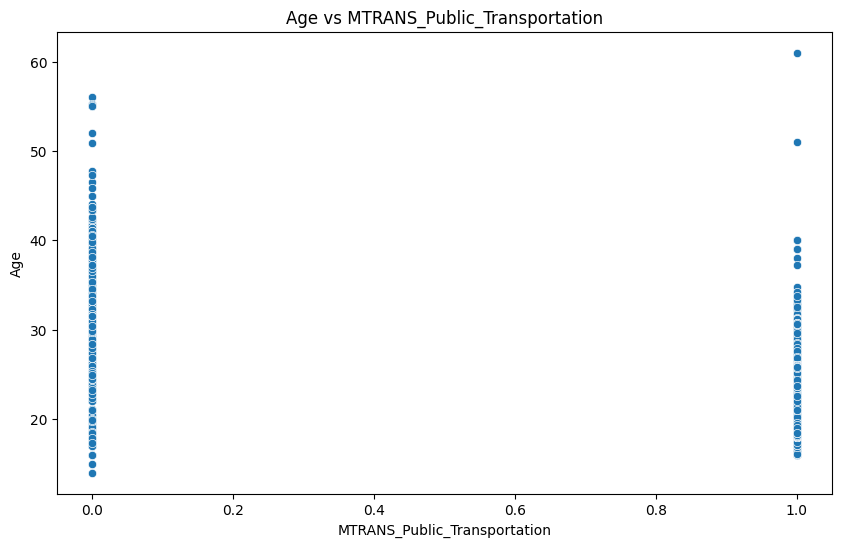

In [212]:
plot_data('MTRANS_Public_Transportation', 'Age', data_clean)

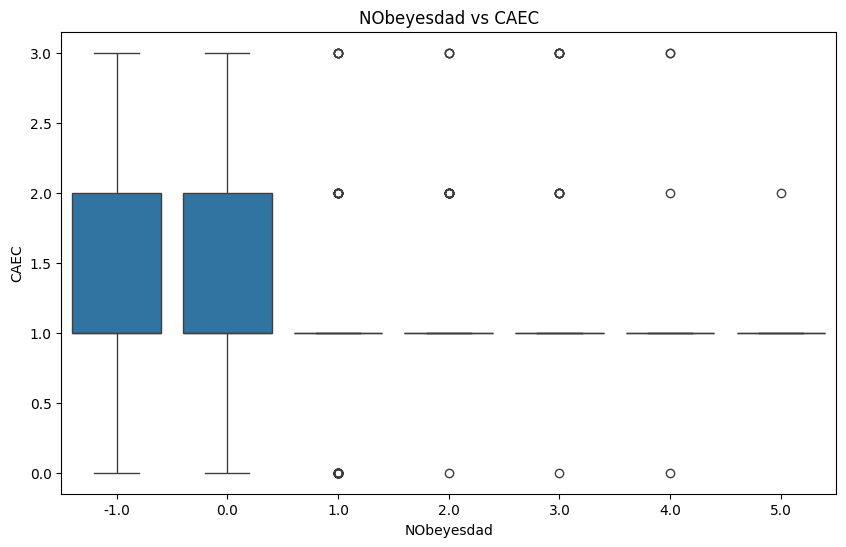

In [213]:
# boxplot of NObeyesdad vs CAEC
plt.figure(figsize=(10, 6))
sns.boxplot(x='NObeyesdad', y='CAEC', data=data_clean)
plt.xlabel('NObeyesdad')
plt.ylabel('CAEC')
plt.title('NObeyesdad vs CAEC')
plt.show()

In [214]:
data_clean['CAEC'].value_counts()

CAEC
1    1764
2     241
3      53
0      51
Name: count, dtype: int64

### Determining Outliers

In [215]:
X = data_clean.drop(columns=['NObeyesdad'])
y = data_clean['NObeyesdad']

# Calculate the mean vector and covariance matrix of the predictors
mean_vector = X.mean().values
cov_matrix = np.cov(X.values.T)

# Calculate Mahalanobis distance for each observation
mahalanobis_distances = X.apply(lambda x: mahalanobis(x, mean_vector, np.linalg.inv(cov_matrix)), axis=1)

# Determine the threshold (e.g., Chi-square distribution with degrees of freedom equal to number of predictors)
threshold = chi2.ppf(0.95, X.shape[1])

# Identify high leverage points
outliers = data_clean[mahalanobis_distances > threshold]
print("Outliers:")
outliers

Outliers:


,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
20,22.000000,1.650000,80.000000,2.0,3.000000,1,50.0,3.000000,2.0,0,2.0,1,1,0,0,0,0,0,0,1
549,29.970445,1.610863,49.516027,109.0,3.904858,2,2.0,0.821977,0.0,0,-1.0,0,1,1,0,0,0,0,1,0


Want to keep both the original data and data without outliers

In [216]:
data_no_outliers = data_clean.drop(outliers.index)

Scale numerical data

In [217]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
std_data_scaled = data_clean.copy()
min_max_data_scaled = data_clean.copy()
robust_data_scaled = data_clean.copy()
std_no_outliers = data_no_outliers.copy()
std_no_outliers[num_features] = std_scaler.fit_transform(std_no_outliers[num_features])
min_max_data_scaled[num_features] = min_max_scaler.fit_transform(min_max_data_scaled[num_features])
robust_data_scaled[num_features] = robust_scaler.fit_transform(robust_data_scaled[num_features])
std_data_scaled[num_features] = std_scaler.fit_transform(std_data_scaled[num_features], std_data_scaled['NObeyesdad'])

In [218]:
std_data_scaled.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.523072,-0.875169,-0.861124,-0.197269,0.404376,1,-0.025408,-1.188443,0.561682,0,0.0,0,1,0,0,0,0,0,1,0
1,-0.523072,-1.946769,-1.166083,0.222745,0.404376,1,0.800090,2.338855,-1.080738,1,0.0,0,1,0,1,1,0,0,1,0
2,-0.207834,1.053709,-0.365567,-0.197269,0.404376,1,-0.025408,1.163089,0.561682,2,0.0,1,1,0,0,0,0,0,1,0
3,0.422641,1.053709,0.015632,0.222745,0.404376,1,-0.025408,1.163089,-1.080738,2,1.0,1,0,0,0,0,0,0,0,1
4,-0.365453,0.839390,0.122367,-0.197269,-2.165781,1,-0.025408,-1.188443,-1.080738,1,2.0,1,0,0,0,0,0,0,1,0


In [219]:
min_max_data_scaled.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.148936,0.320755,0.362573,0.009259,0.666667,1,0.020408,0.000000,0.5,0,0.0,0,1,0,0,0,0,0,1,0
1,0.148936,0.132075,0.315789,0.018519,0.666667,1,0.040816,1.000000,0.0,1,0.0,0,1,0,1,1,0,0,1,0
2,0.191489,0.660377,0.438596,0.009259,0.666667,1,0.020408,0.666667,0.5,2,0.0,1,1,0,0,0,0,0,1,0
3,0.276596,0.660377,0.497076,0.018519,0.666667,1,0.020408,0.666667,0.0,2,1.0,1,0,0,0,0,0,0,0,1
4,0.170213,0.622642,0.513450,0.009259,0.000000,1,0.020408,0.000000,0.0,1,2.0,1,0,0,0,0,0,0,1,0


In [220]:
robust_data_scaled.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.295799,-0.581250,-0.452813,-0.387426,0.0000,1,0.000000,-0.649545,0.37465,0,0.0,0,1,0,0,0,0,0,1,0
1,-0.295799,-1.303308,-0.643471,0.612574,0.0000,1,1.109792,1.299089,-0.62535,1,0.0,0,1,0,1,1,0,0,1,0
2,0.034813,0.718455,-0.142994,-0.387426,0.0000,1,0.000000,0.649545,0.37465,2,0.0,1,1,0,0,0,0,0,1,0
3,0.696036,0.718455,0.095329,0.612574,0.0000,1,0.000000,0.649545,-0.62535,2,1.0,1,0,0,0,0,0,0,0,1
4,-0.130493,0.574043,0.162059,-0.387426,-5.8589,1,0.000000,-0.649545,-0.62535,1,2.0,1,0,0,0,0,0,0,1,0


# Supervised Learning Methods

## Best Models, Overview

Standardization seems to be the scaling method to choose here

In [221]:
X_std = std_data_scaled.drop(columns='NObeyesdad')
y_std = std_data_scaled['NObeyesdad'] # response is obesity level
X_std_no_outliers = std_no_outliers.drop(columns='NObeyesdad')
y_std_no_outliers = std_no_outliers['NObeyesdad']
X_min_max = min_max_data_scaled.drop(columns='NObeyesdad')
y_min_max = min_max_data_scaled['NObeyesdad']
X_robust = robust_data_scaled.drop(columns='NObeyesdad')
y_robust = robust_data_scaled['NObeyesdad']

# Context manager to suppress stdout and stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier()
}

# Evaluate models using cross-validation (5 folds)
for name, model in models.items():
    with suppress_stdout_stderr(), warnings.catch_warnings():
        warnings.simplefilter('ignore')
        std_cv_scores = cross_val_score(model, X_std, y_std, cv=5, scoring='accuracy')
        std_cv_scores_no_outliers = cross_val_score(model, X_std_no_outliers, y_std_no_outliers, cv=5, scoring='accuracy')
        min_max_cv_scores = cross_val_score(model, X_min_max, y_min_max, cv=5, scoring='accuracy')
        robust_cv_scores = cross_val_score(model, X_robust, y_robust, cv=5, scoring='accuracy')
    print(f'{name} CV Accuracy (std data): {std_cv_scores.mean()}')
    print(f'{name} CV Accuracy (std data, no outliers): {std_cv_scores_no_outliers.mean()}')
    print(f'{name} CV Accuracy (min-max data): {min_max_cv_scores.mean()}')
    print(f'{name} CV Accuracy (robust data): {robust_cv_scores.mean()}')

Logistic Regression CV Accuracy (std data): 0.8710506467336853
Logistic Regression CV Accuracy (std data, no outliers): 0.870490031633101
Logistic Regression CV Accuracy (min-max data): 0.649608807736038
Logistic Regression CV Accuracy (robust data): 0.8302788440972183
KNN CV Accuracy (std data): 0.849707872251804
KNN CV Accuracy (std data, no outliers): 0.84151140930531
KNN CV Accuracy (min-max data): 0.7871384989474395
KNN CV Accuracy (robust data): 0.8307460233477052
LDA CV Accuracy (std data): 0.876269545541534
LDA CV Accuracy (std data, no outliers): 0.8780729700217267
LDA CV Accuracy (min-max data): 0.876269545541534
LDA CV Accuracy (robust data): 0.876269545541534
SVM CV Accuracy (std data): 0.9156263016289359
SVM CV Accuracy (std data, no outliers): 0.9150938298566942
SVM CV Accuracy (min-max data): 0.730230437572469
SVM CV Accuracy (robust data): 0.845928786121962
Decision Tree CV Accuracy (std data): 0.9274656369960936
Decision Tree CV Accuracy (std data, no outliers): 0.9269

Now going back to a simpler approach

## Logistic Regression

In [222]:
def hybrid_feature_selection(X, y, initial_features=[]):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        included = list(initial_features)
        best_score = float('inf')
        while True:
            changed = False
            
            # Forward step
            excluded = list(set(X.columns) - set(included))
            for new_feature in excluded:
                try:
                    try_features = included + [new_feature]
                    X_train_subset = sm.add_constant(X[try_features])
                    model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                    score = model.aic
                    if score < best_score:
                        best_score = score
                        best_feature = new_feature
                        changed = True
                except (np.linalg.LinAlgError, ValueError):
                    continue
            if changed:
                included.append(best_feature)
                print(f'Forward step: {included} (AIC: {best_score})')
            
            worst_feature = ''
            # Backward step
            for feature in included:
                try:
                    try_features = list(set(included) - {feature})
                    if not try_features:
                        continue
                    X_train_subset = sm.add_constant(X[try_features])
                    model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                    score = model.aic
                    if score < best_score:
                        best_score = score
                        worst_feature = feature
                        changed = True
                except (np.linalg.LinAlgError, ValueError):
                    continue
            if changed and len(worst_feature) > 0:
                included.remove(worst_feature)
                print(f'Backward step: {included} (AIC: {best_score})')
            
            if not changed:
                break

        return included

In [223]:
# Use the hybrid feature selection to find the best subset of features
hybrid_features = hybrid_feature_selection(X_std, y_std)
print('Best subset of features:', hybrid_features)

Forward step: ['Weight'] (AIC: 4240.91748704769)
Forward step: ['Weight', 'FCVC'] (AIC: 3819.1931846346033)
Forward step: ['Weight', 'FCVC', 'Age'] (AIC: 3609.1301194855555)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP'] (AIC: 3393.9895316683205)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF'] (AIC: 3169.6475907023387)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC'] (AIC: 3004.966821669967)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O'] (AIC: 2881.0796043541177)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC'] (AIC: 2782.3387923247064)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC'] (AIC: 2690.532744543125)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation'] (AIC: 2606.0540758674415)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_histo

In [224]:
def fit_and_evaluate(model, X, y, report=True):
    # reserve 10% for testing on unseen data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if report:
        print(classification_report(y_test, y_pred))
        # print confusion heatmap
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'CV Accuracy: {cv_score.mean()}')
    return model

Seems as though we're failing to get the optimal set of features, as the full model still out-performs the one fit on the hybrid subset.

              precision    recall  f1-score   support

        -1.0       0.81      0.81      0.81        26
         0.0       0.58      0.62      0.60        29
         1.0       0.63      0.63      0.63        30
         2.0       0.59      0.47      0.52        34
         3.0       0.67      0.75      0.71        32
         4.0       0.96      0.92      0.94        26
         5.0       0.94      1.00      0.97        34

    accuracy                           0.74       211
   macro avg       0.74      0.74      0.74       211
weighted avg       0.74      0.74      0.74       211



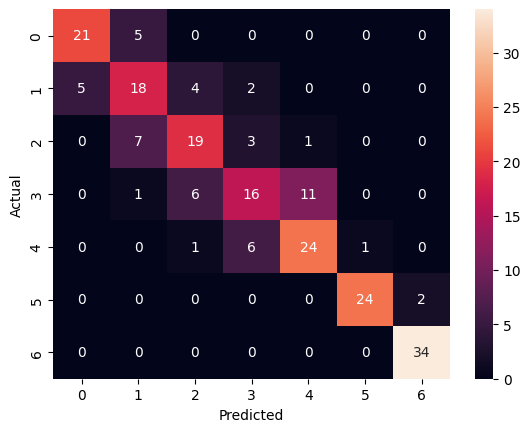

Test Accuracy: 0.7393364928909952
CV Accuracy: 0.7423621719205666


In [225]:
# suppress ConvergenceWarning
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    log_reg = LogisticRegression(random_state=42)
    log_reg_fit = fit_and_evaluate(log_reg, X_std[hybrid_features], y_std)

Assuming that cv score is a better estimate of performance, removing outliers only offers a slight improvement.

              precision    recall  f1-score   support

        -1.0       0.69      0.79      0.73        28
         0.0       0.50      0.30      0.38        33
         1.0       0.57      0.50      0.53        34
         2.0       0.50      0.58      0.54        19
         3.0       0.58      0.70      0.63        27
         4.0       0.95      1.00      0.97        36
         5.0       0.94      1.00      0.97        34

    accuracy                           0.71       211
   macro avg       0.67      0.70      0.68       211
weighted avg       0.69      0.71      0.69       211



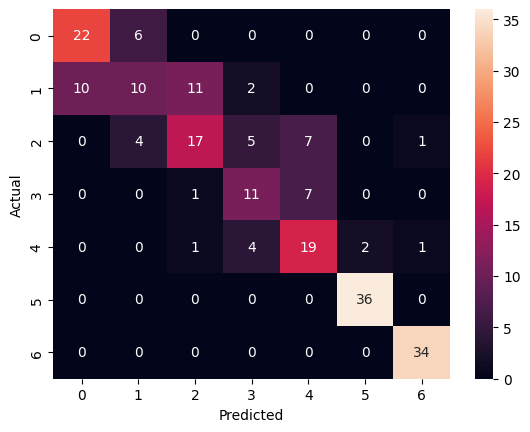

Test Accuracy: 0.7061611374407583
CV Accuracy: 0.7521205388140536


In [226]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    log_reg_2 = LogisticRegression(random_state=42)
    log_reg_fit_2 = fit_and_evaluate(log_reg_2, X_std_no_outliers[hybrid_features], y_std_no_outliers)

## Decision Trees

Single Tree, Grid Search

In [227]:
dt = DecisionTreeClassifier(random_state=42, max_features=X_std.shape[1])

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                        scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_std, y_std)

# Print the best parameters and the corresponding score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_}')

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation accuracy: 0.9284213844266078


              precision    recall  f1-score   support

        -1.0       0.93      0.96      0.94        26
         0.0       0.96      0.93      0.95        29
         1.0       1.00      1.00      1.00        30
         2.0       1.00      1.00      1.00        34
         3.0       1.00      1.00      1.00        32
         4.0       1.00      1.00      1.00        26
         5.0       1.00      1.00      1.00        34

    accuracy                           0.99       211
   macro avg       0.98      0.98      0.98       211
weighted avg       0.99      0.99      0.99       211



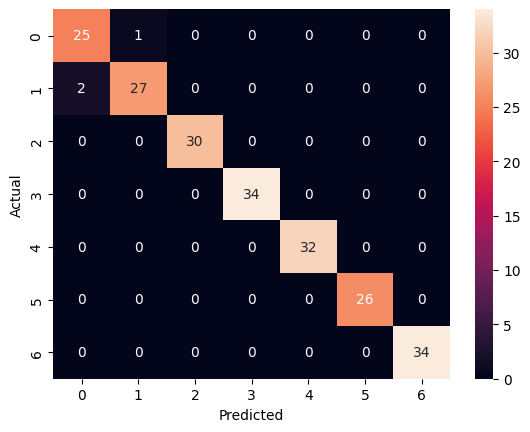

Test Accuracy: 0.985781990521327
CV Accuracy: 0.9394209137619776


In [228]:
dt_best = fit_and_evaluate(grid_search.best_estimator_, X_std, y_std)

In [229]:
data['NObeyesdad'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II', nan,
       'Obesity_Type_III'], dtype=object)

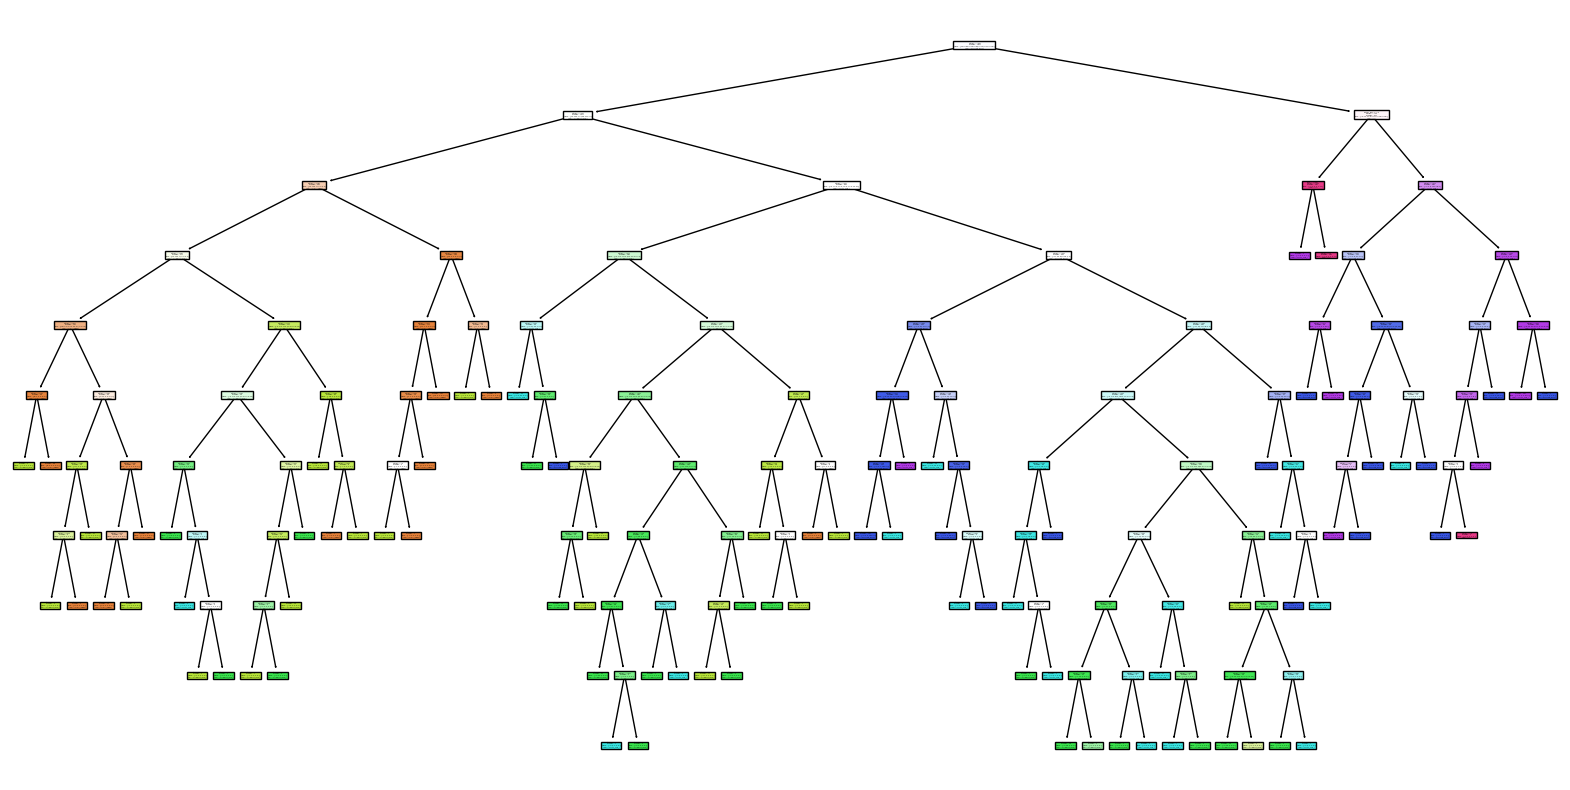

In [230]:
# visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(grid_search.best_estimator_, filled=True, feature_names=X_std.columns, class_names=data['NObeyesdad'].unique().astype(str))
plt.show()

Bagging

              precision    recall  f1-score   support

        -1.0       0.87      1.00      0.93        26
         0.0       0.88      0.76      0.81        29
         1.0       0.90      0.90      0.90        30
         2.0       1.00      1.00      1.00        34
         3.0       1.00      0.97      0.98        32
         4.0       0.96      1.00      0.98        26
         5.0       1.00      1.00      1.00        34

    accuracy                           0.95       211
   macro avg       0.94      0.95      0.94       211
weighted avg       0.95      0.95      0.95       211



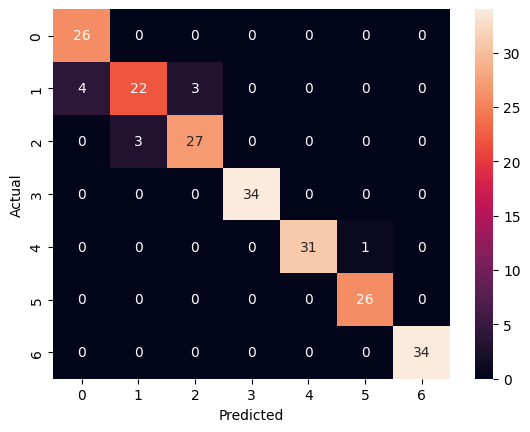

Test Accuracy: 0.9478672985781991
CV Accuracy: 0.951534509095959


In [231]:
bag_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_features=X_std.shape[1])
bag_clf_fit = fit_and_evaluate(bag_clf, X_std, y_std)

Random Forest

              precision    recall  f1-score   support

        -1.0       0.96      0.92      0.94        26
         0.0       0.74      0.97      0.84        29
         1.0       0.96      0.77      0.85        30
         2.0       0.91      0.94      0.93        34
         3.0       1.00      0.91      0.95        32
         4.0       1.00      1.00      1.00        26
         5.0       1.00      1.00      1.00        34

    accuracy                           0.93       211
   macro avg       0.94      0.93      0.93       211
weighted avg       0.94      0.93      0.93       211



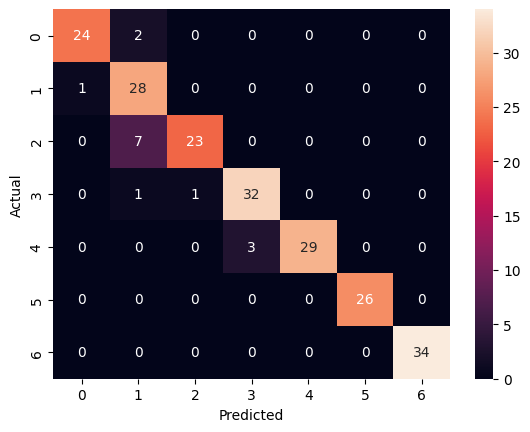

Test Accuracy: 0.9289099526066351
CV Accuracy: 0.9494306346340785


In [232]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_features='sqrt')
rf = fit_and_evaluate(rf, X_std, y_std)

Boosting

              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96        26
         0.0       0.87      0.90      0.88        29
         1.0       0.96      0.87      0.91        30
         2.0       0.97      1.00      0.99        34
         3.0       1.00      0.94      0.97        32
         4.0       0.96      1.00      0.98        26
         5.0       1.00      1.00      1.00        34

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211



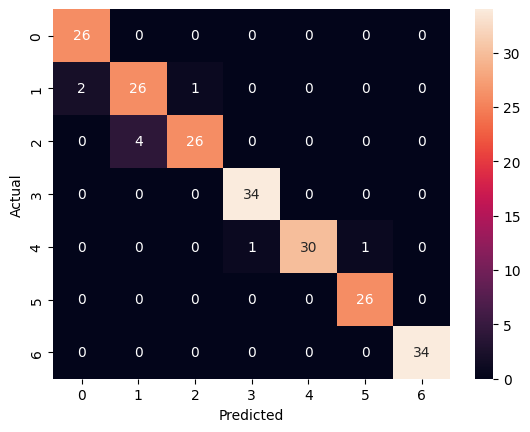

Test Accuracy: 0.957345971563981
CV Accuracy: 0.9615497847521178


In [233]:
learning_rates = [0.01, 0.1, 0.5]
n_estimators = [50, 100, 200]
max_features = ['sqrt', 'log2', None]
models = []
for lr in learning_rates:
    for n in n_estimators:
        for max_feat in max_features:
            gb = GradientBoostingClassifier(random_state=42, n_estimators=n, learning_rate=lr, max_features=max_feat)
            models.append(gb)

best_gb = max(models, key=lambda x: cross_val_score(x, X_std, y_std, cv=5, scoring='accuracy').mean())
best_gb = fit_and_evaluate(best_gb, X_std, y_std)

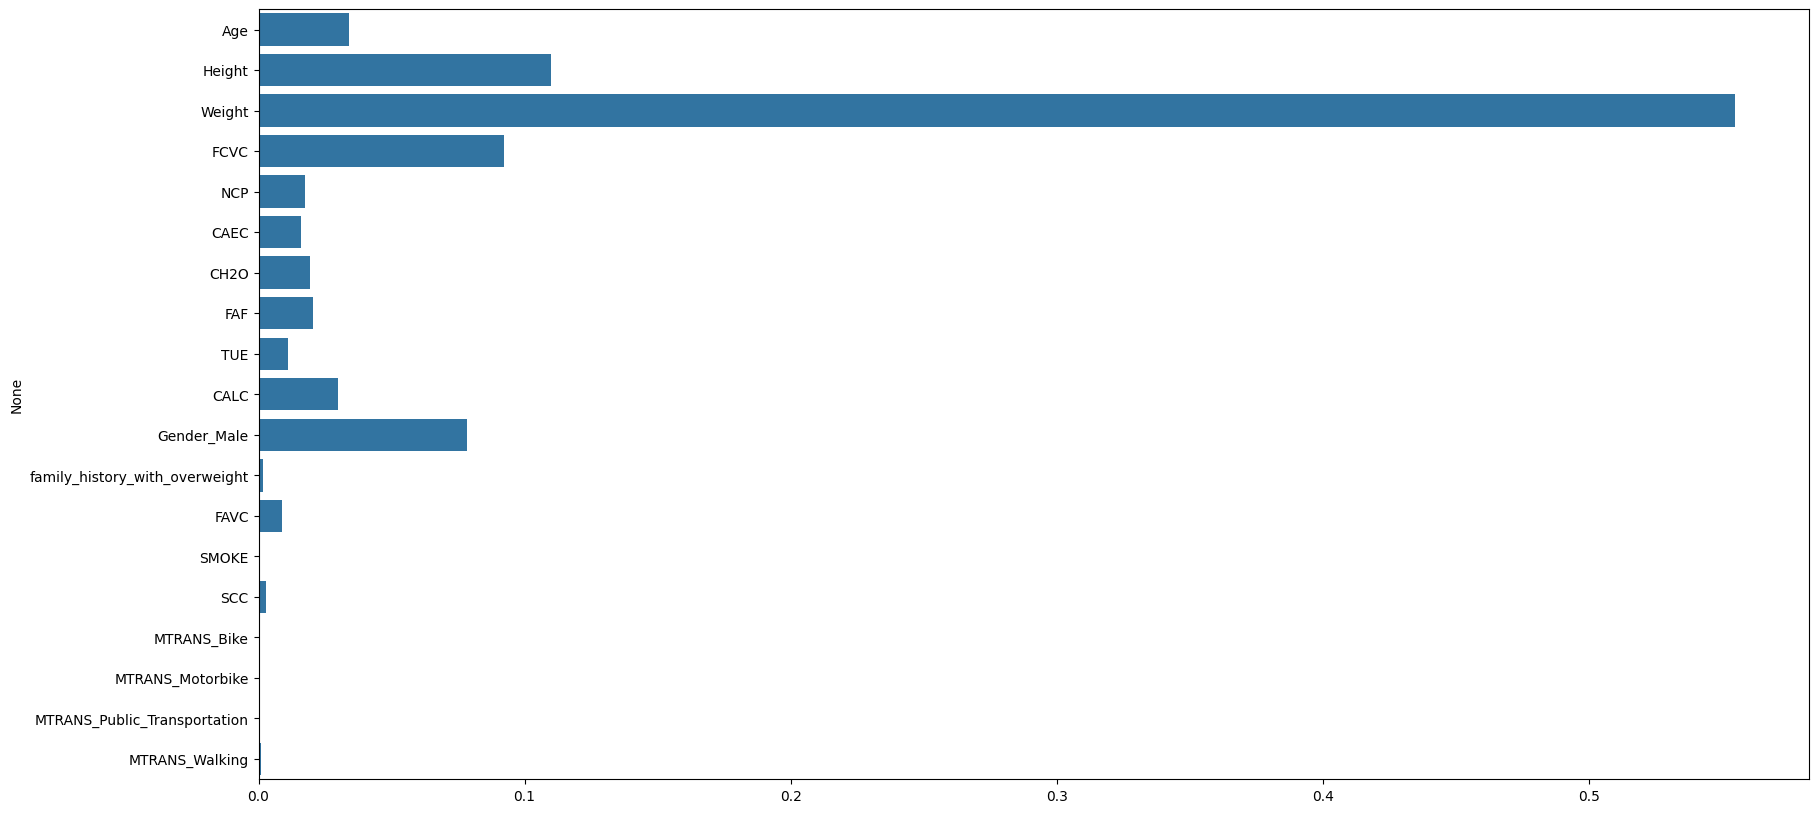

In [234]:
# feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x=best_gb.feature_importances_, y=X_std.columns)
plt.show()

## Neural Network

In [235]:
# Define the parameter grid
learning_modes = ['constant', 'invscaling', 'adaptive']
solvers = ['lbfgs', 'sgd', 'adam']
activations = ['identity', 'logistic', 'tanh', 'relu']

# Initialize a list to store results
results = []

# Loop through all parameter combinations (total of 36)
for learning_mode in learning_modes:
    for solver in solvers:
        for activation in activations:
            mlp = MLPClassifier(
                random_state=42,
                learning_rate=learning_mode,
                solver=solver,
                activation=activation,
                max_iter=500  # Increase max_iter to help with convergence
            )
            
            # Capture convergence warnings
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                
                try:
                    # Perform cross-validation
                    score = cross_val_score(mlp, X_std, y_std, cv=5, scoring='accuracy').mean()
                    results.append({
                        'learning_rate': learning_mode,
                        'solver': solver,
                        'activation': activation,
                        'accuracy': score
                    })
                except ConvergenceWarning:
                    print(f"Convergence warning for {learning_mode}, {solver}, {activation}")

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Find the best parameters based on the highest accuracy
best_params = results_df.loc[results_df['accuracy'].idxmax()]

print("Best Parameters:")
print(best_params)

Best Parameters:
learning_rate    constant
solver              lbfgs
activation       identity
accuracy         0.948336
Name: 0, dtype: object


              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96        26
         0.0       0.88      0.97      0.92        29
         1.0       0.96      0.87      0.91        30
         2.0       0.97      0.97      0.97        34
         3.0       1.00      1.00      1.00        32
         4.0       1.00      1.00      1.00        26
         5.0       1.00      1.00      1.00        34

    accuracy                           0.97       211
   macro avg       0.97      0.97      0.97       211
weighted avg       0.97      0.97      0.97       211



c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


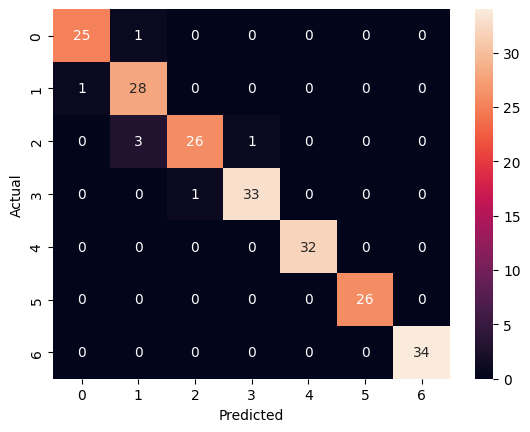

Test Accuracy: 0.966824644549763


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptr

CV Accuracy: 0.9625996389390362


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='identity', random_state=42, solver='lbfgs')

In [236]:
fit_and_evaluate(MLPClassifier(random_state=42, learning_rate=best_params['learning_rate'], solver=best_params['solver'], activation=best_params['activation']), X_std, y_std)

## SVM

              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96        26
         0.0       0.96      0.93      0.95        29
         1.0       0.93      0.90      0.92        30
         2.0       0.91      0.94      0.93        34
         3.0       1.00      0.97      0.98        32
         4.0       1.00      1.00      1.00        26
         5.0       1.00      1.00      1.00        34

    accuracy                           0.96       211
   macro avg       0.96      0.96      0.96       211
weighted avg       0.96      0.96      0.96       211



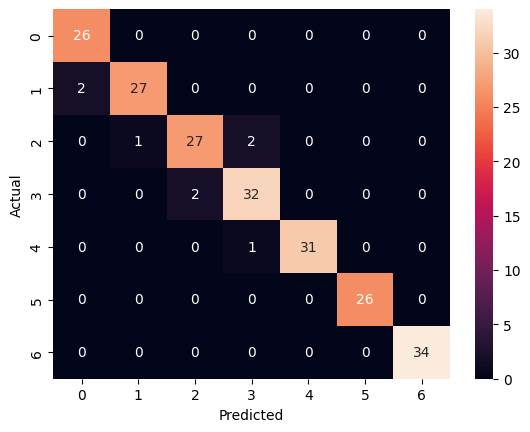

Test Accuracy: 0.9620853080568721
CV Accuracy: 0.9620719344535482


In [237]:
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10]
gammas = ['scale', 'auto']
models = []
for kernel in kernel_types:
    for C in C_values:
        for gamma in gammas:
            svm = SVC(random_state=42, kernel=kernel, C=C, gamma=gamma)
            models.append(svm)

best_svm = max(models, key=lambda x: cross_val_score(x, X_std, y_std, cv=5, scoring='accuracy').mean())
best_svm = fit_and_evaluate(best_svm, X_std, y_std)

              precision    recall  f1-score   support

        -1.0       0.90      1.00      0.95        28
         0.0       0.97      0.88      0.92        33
         1.0       0.94      0.97      0.96        34
         2.0       0.95      0.95      0.95        19
         3.0       1.00      0.96      0.98        27
         4.0       1.00      1.00      1.00        36
         5.0       1.00      1.00      1.00        34

    accuracy                           0.97       211
   macro avg       0.97      0.97      0.96       211
weighted avg       0.97      0.97      0.97       211



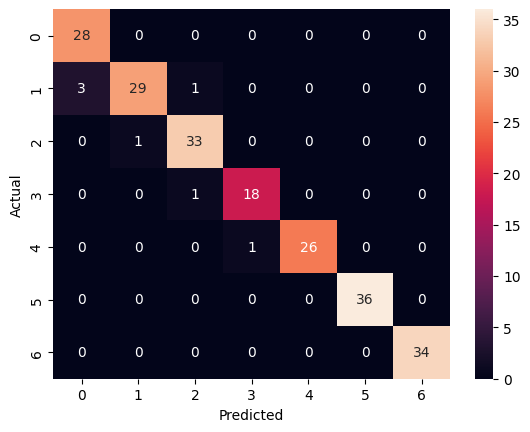

Test Accuracy: 0.966824644549763
CV Accuracy: 0.9662449659769476


In [238]:
best_svm_no_outliers = max(models, key=lambda x: cross_val_score(x, X_std_no_outliers, y_std_no_outliers, cv=5, scoring='accuracy').mean())
best_svm_no_outliers = fit_and_evaluate(best_svm_no_outliers, X_std_no_outliers, y_std_no_outliers)

# Unsupervised Learning Methods

PCA

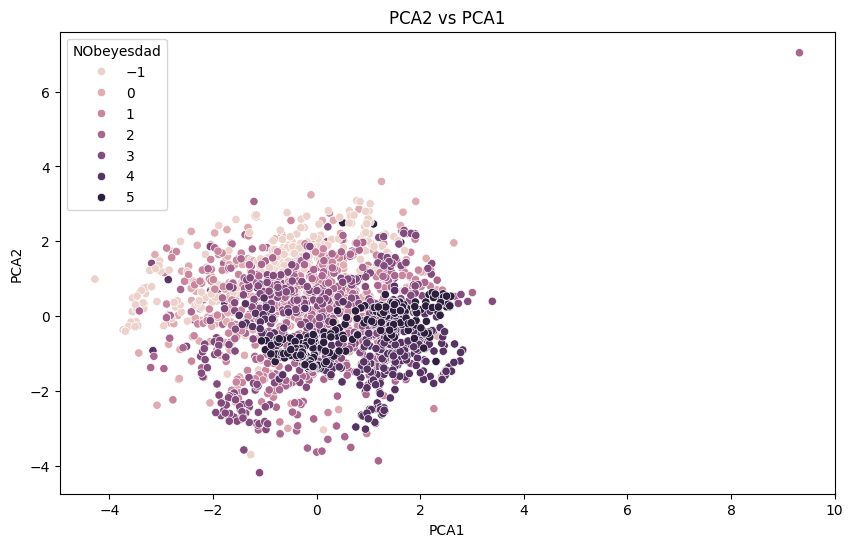

In [239]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
PCA_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2']) # for easy plotting
# visualize the data
plot_data('PCA1', 'PCA2', PCA_df, y_std)

KMeans

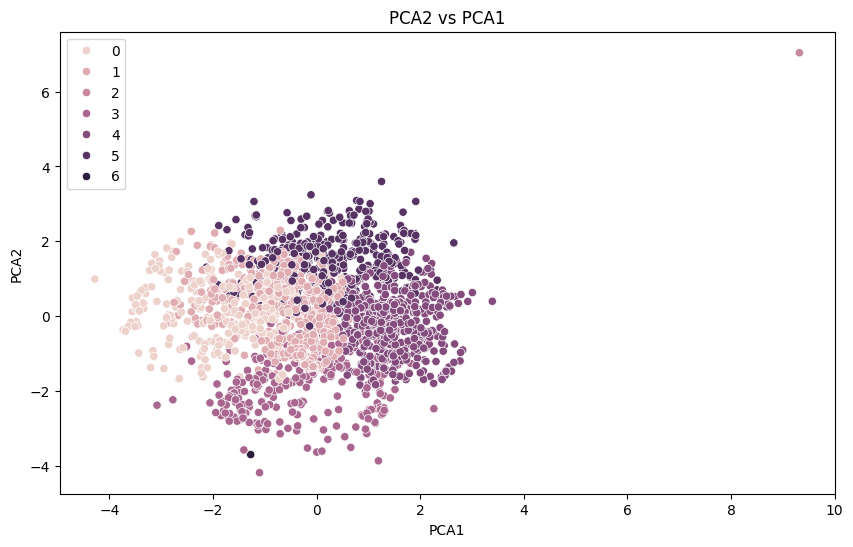

In [240]:
# KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X_std)
y_kmeans = kmeans.predict(X_std)
# visualize the data
plot_data('PCA1', 'PCA2', PCA_df, y_kmeans)

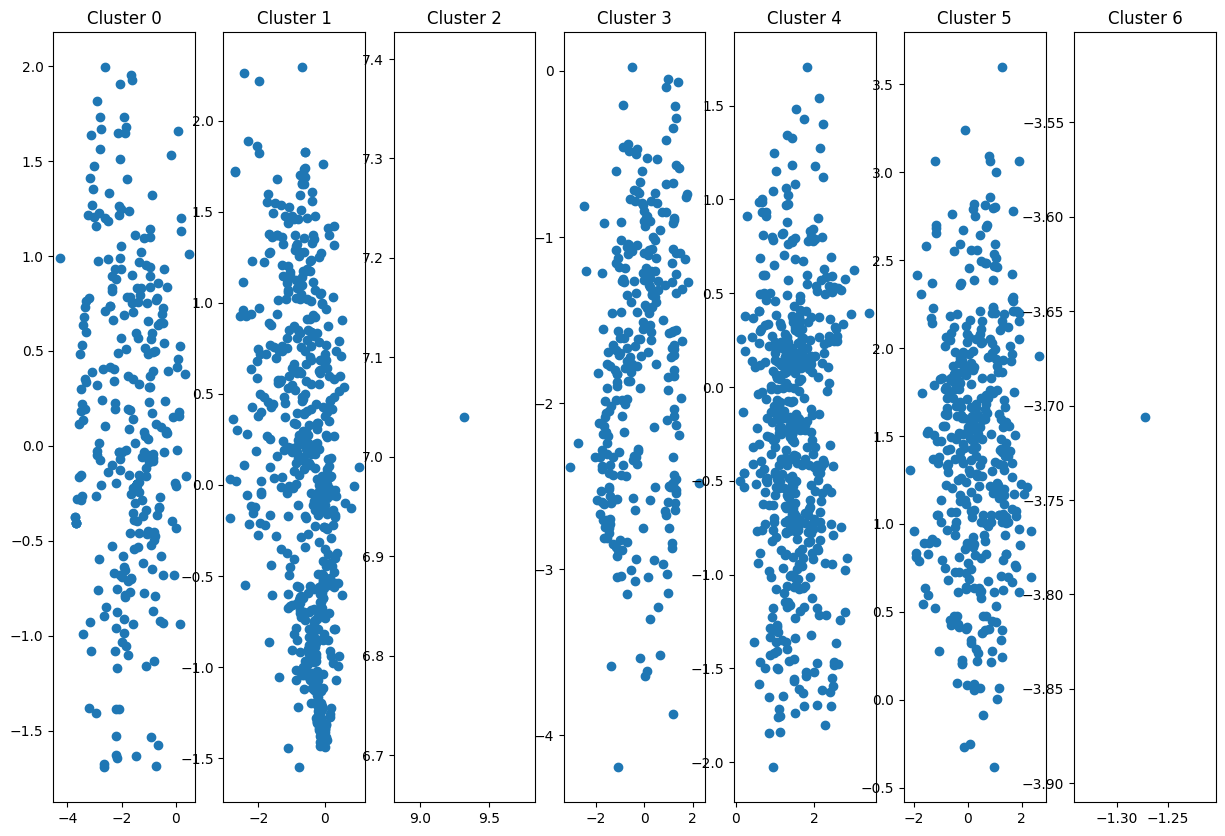

In [241]:
# plot each cluster individually on different subplots
plt.figure(figsize=(15, 10))
for i in range(7):
    plt.subplot(1, 7, i+1)
    cluster = PCA_df[y_kmeans == i]
    plt.scatter(cluster['PCA1'], cluster['PCA2'])
    plt.title(f'Cluster {i}')

In [242]:
# Calculate the distance from the origin in the PCA space
distances = np.linalg.norm(X_pca, axis=1)

# Determine a threshold for outliers
threshold = np.mean(distances) + 3 * np.std(distances)

# Identify outliers
outliers = X_std[distances > threshold]
outliers

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
20,-0.365453,-0.553690,-0.251207,-0.197269,0.404376,1,39.598466,2.338855,2.204102,0,1,1,0,0,0,0,0,0,1
21,4.363113,-0.125050,0.015632,0.222745,-2.165781,1,-0.025408,-1.188443,-1.080738,0,0,1,1,1,0,0,0,0,0
252,4.993589,0.946550,0.129991,-0.197269,0.404376,1,-0.025408,-0.012677,-1.080738,2,1,1,0,1,0,0,0,0,0
605,-0.774127,-1.937532,-3.224554,0.222745,-2.165781,2,-0.150303,-1.188443,0.142134,1,0,0,1,0,0,0,0,1,0


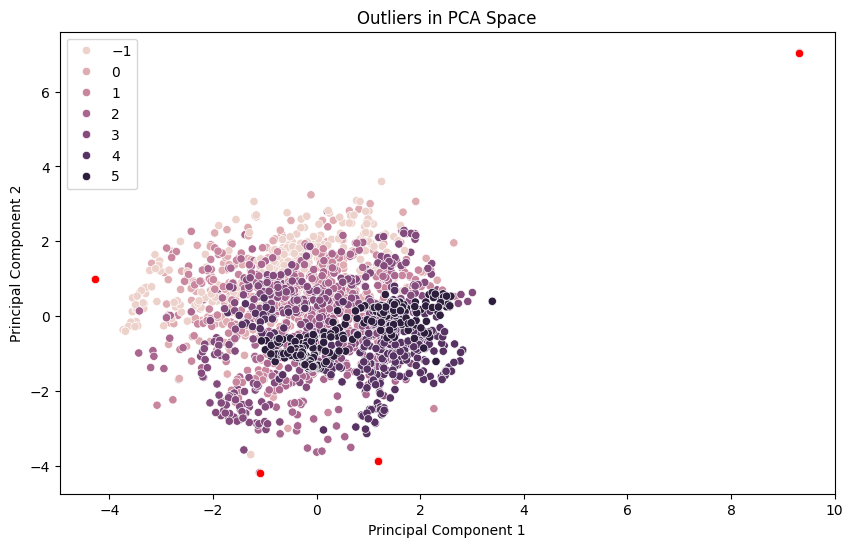

In [243]:
# show the outliers in the PCA space
outliers_pca = pca.transform(outliers)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_std)
sns.scatterplot(x=outliers_pca[:, 0], y=outliers_pca[:, 1], color='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Outliers in PCA Space')
plt.show()

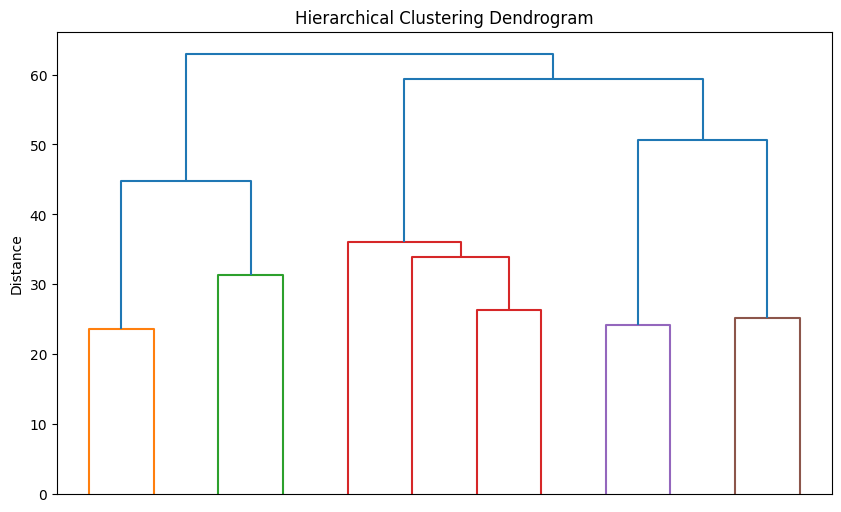

In [244]:
# hierarchical clustering
Z = linkage(X_std_no_outliers, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='lastp', p=12)
plt.title(f'Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
# remove the x-axis labels (there were too many)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

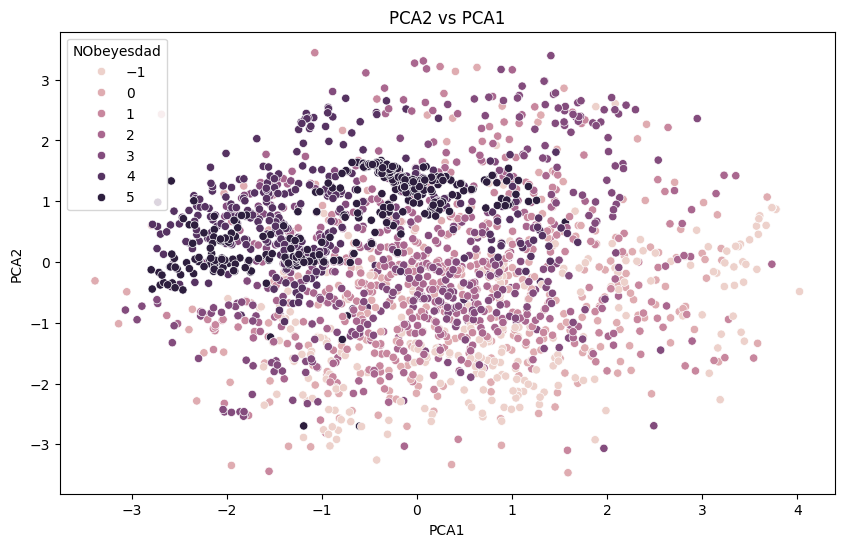

In [245]:
X_pca_no_outliers = pca.fit_transform(X_std_no_outliers)
PCA_df_no_outliers = pd.DataFrame(data=X_pca_no_outliers, columns=['PCA1', 'PCA2'])
plot_data('PCA1', 'PCA2', PCA_df_no_outliers, y_std_no_outliers)

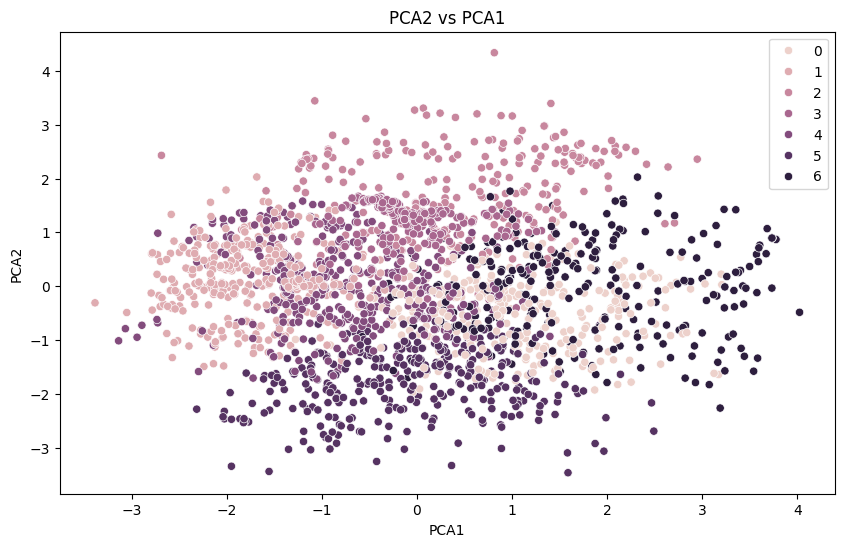

In [246]:
# KMeans
kmeans_no_outliers = KMeans(n_clusters=7, random_state=42)
kmeans_no_outliers.fit(X_std_no_outliers)
y_kmeans_no_outliers = kmeans_no_outliers.predict(X_std_no_outliers)
plot_data('PCA1', 'PCA2', PCA_df_no_outliers, y_kmeans_no_outliers)

In [247]:
# what types of people are in each cluster?
cluster_df = data_no_outliers.copy()
cluster_df['Cluster'] = y_kmeans_no_outliers
cluster_df.groupby('Cluster').mean().sort_values('NObeyesdad', ascending=False)

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
Cluster,,,,,,,,,,,,,,,,,,,,
3,25.369508,1.643956,107.038074,2.979147,2.990584,1.009615,2.186474,0.120562,0.487557,1.000000,4.740385,0.024038,0.990385,0.985577,0.004808,0.000000,0.000000,0.004808,0.975962,0.004808
1,23.322955,1.789766,115.524809,2.885265,2.958371,1.052941,2.300818,1.532855,0.642580,0.970588,3.479412,0.600000,0.952941,0.958824,0.020588,0.029412,0.002941,0.005882,0.764706,0.026471
4,24.569115,1.781482,100.741892,1.948111,2.789667,1.102362,2.061402,0.739679,0.617954,0.845144,2.721785,0.976378,0.950131,0.955381,0.031496,0.010499,0.000000,0.005249,0.727034,0.020997
2,37.266371,1.663567,84.543120,2.392194,2.533898,1.073930,1.757673,0.898026,0.220108,0.610895,2.400778,0.431907,0.929961,0.910506,0.023346,0.011673,0.003891,0.007782,0.136187,0.003891
6,21.564027,1.620748,69.438269,2.375244,1.161341,1.106383,1.905791,0.678613,0.691043,0.570922,1.255319,0.340426,0.613475,0.847518,0.017730,0.078014,0.000000,0.007092,0.936170,0.024823
0,20.577356,1.633168,62.476460,2.518821,3.103384,1.355556,1.673388,1.102311,0.465864,0.558730,0.542857,0.231746,0.568254,0.676190,0.019048,0.139683,0.006349,0.006349,0.885714,0.038095
5,20.148311,1.720112,66.587589,2.088323,3.115522,1.231481,2.136361,1.637228,1.334063,0.583333,0.339506,0.632716,0.740741,0.870370,0.021605,0.040123,0.009259,0.000000,0.799383,0.052469


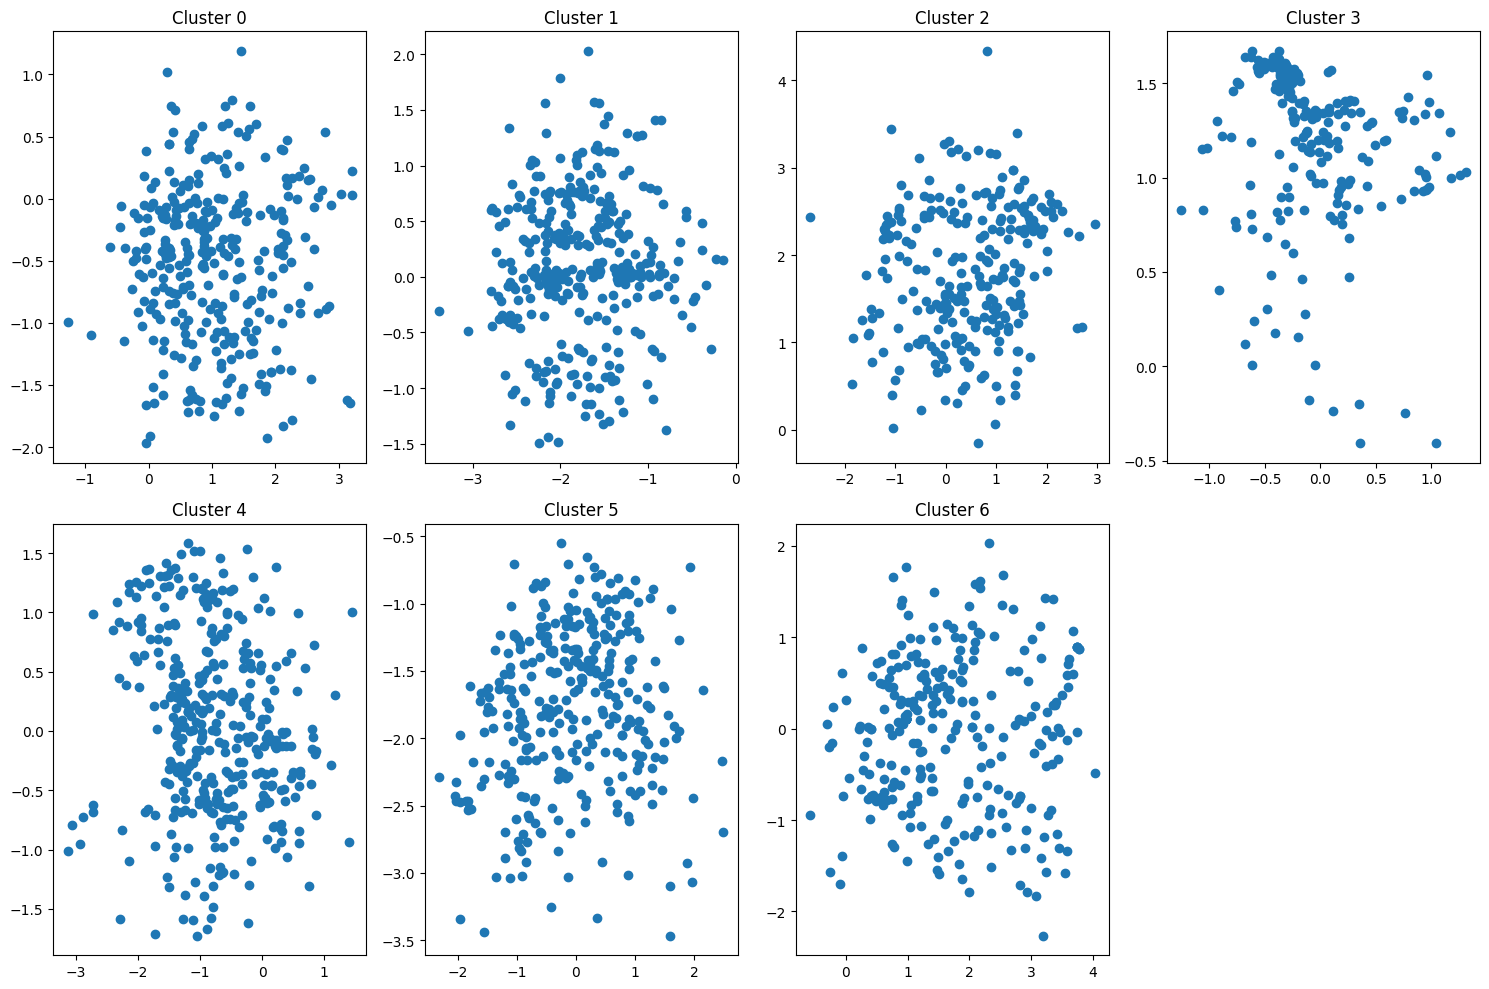

In [248]:
# Plot each cluster individually on different subplots
plt.figure(figsize=(15, 10))
gs = GridSpec(2, 4)  # Create a grid with 2 rows and 4 columns

for i in range(7):
    ax = plt.subplot(gs[i // 4, i % 4])  # Access subplots in the grid
    cluster = PCA_df_no_outliers[y_kmeans_no_outliers == i]
    ax.scatter(cluster['PCA1'], cluster['PCA2'])
    ax.set_title(f'Cluster {i}')

plt.tight_layout()
plt.show()

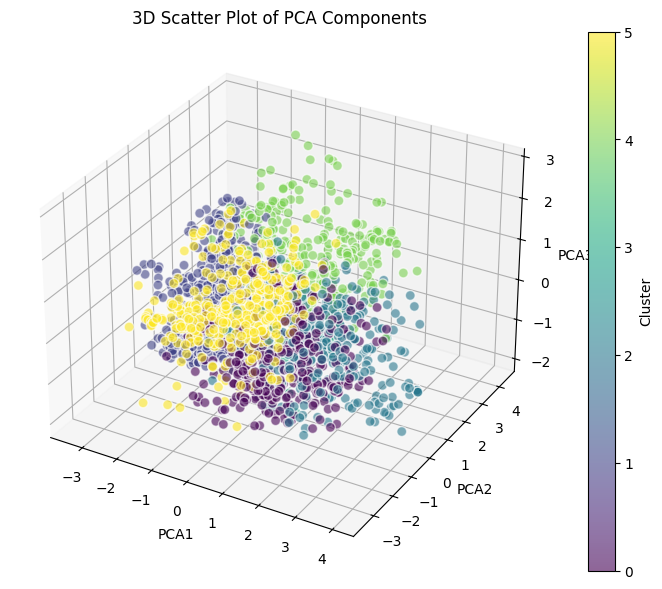

In [249]:
# Sample data and clustering (replace with your actual data)
# X_std_no_outliers is your standardized data without outliers

# Apply PCA to reduce dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std_no_outliers)

# Fit KMeans
kmeans_no_outliers = KMeans(n_clusters=6, random_state=42)
kmeans_no_outliers.fit(X_std_no_outliers)
y_kmeans_no_outliers = kmeans_no_outliers.predict(X_std_no_outliers)

# Create a DataFrame with PCA results
PCA_df_no_outliers = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2', 'PCA3'])

# Plotting function for 3D scatter plot
def plot_3d_scatter(x, y, z, labels, title="3D Scatter Plot"):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
    
    # Adding labels
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title(title)
    
    # Adding a color bar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Cluster')
    
    plt.show()

plt.ion()

# Call the plotting function
plot_3d_scatter(
    PCA_df_no_outliers['PCA1'], 
    PCA_df_no_outliers['PCA2'], 
    PCA_df_no_outliers['PCA3'], 
    y_kmeans_no_outliers,
    title="3D Scatter Plot of PCA Components"
)